Automatic Detection of Road Damage - Classification Project

Classify road damage into four categories: good, poor, satisfactory, and very poor using images.
By that this classification model can help in prioritizing road maintenance.


In [3]:
import kagglehub

# Download dataset from the kaggle 
path = kagglehub.dataset_download("prudhvignv/road-damage-classification-and-assessment")

print("Path to dataset files:", path)

Path to dataset files: /Users/asylkaziahmetova/.cache/kagglehub/datasets/prudhvignv/road-damage-classification-and-assessment/versions/1


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import seaborn as sns


/Users/asylkaziahmetova/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [16]:
# path to the dataset 
DATASET_PATH = "/Users/asylkaziahmetova/.cache/kagglehub/datasets/prudhvignv/road-damage-classification-and-assessment/versions/1"

# Parameters of the models 
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_CLASSES = 4
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

# Load the full dataset with transformations
dataset = ImageFolder(root=os.path.join(DATASET_PATH, "sih_road_dataset"), transform=train_transforms)

# Get the size of the dataset
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)  # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

# Split dataset into train, validation, and test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

print(f"Dataset sizes - Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

# Apply specific transforms for validation and test data
val_data.dataset.transform = val_transforms
test_data.dataset.transform = val_transforms

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


Dataset sizes - Train: 1451, Validation: 311, Test: 312


In [18]:
# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [19]:
# get the classes' names
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['good', 'poor', 'satisfactory', 'very_poor']


In [20]:
# Load a pretrained model resnet50
model = models.resnet50(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.to(DEVICE)


/Users/asylkaziahmetova/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/asylkaziahmetova/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [22]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(dataloader), accuracy

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(dataloader), accuracy


In [23]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


Epoch 1/10
Train Loss: 0.3312, Train Accuracy: 88.77%
Val Loss: 6.1680, Val Accuracy: 65.92%
Epoch 2/10
Train Loss: 0.2090, Train Accuracy: 93.11%
Val Loss: 0.1773, Val Accuracy: 93.57%
Epoch 3/10
Train Loss: 0.2114, Train Accuracy: 92.42%
Val Loss: 0.3126, Val Accuracy: 86.50%


KeyboardInterrupt: 

              precision    recall  f1-score   support

        good       1.00      1.00      1.00       122
        poor       0.77      0.80      0.79        66
satisfactory       0.86      0.60      0.71        73
   very_poor       0.73      1.00      0.84        51

    accuracy                           0.87       312
   macro avg       0.84      0.85      0.83       312
weighted avg       0.87      0.87      0.86       312



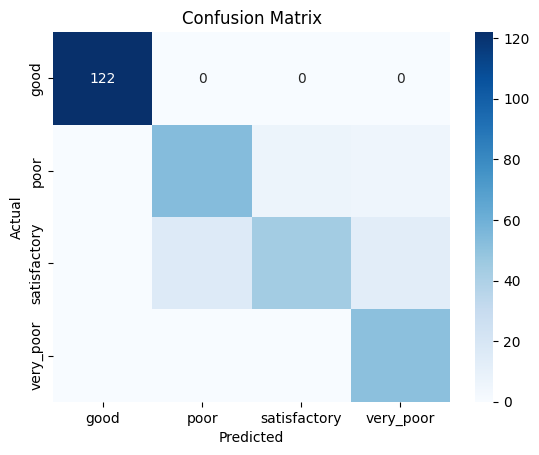

In [24]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Evaluate
test_preds, test_labels = evaluate_model(model, test_loader)

# Classification Report
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [27]:
torch.save(model.state_dict(), "road_damage_model1.pth")
print("Model saved as road_damage_model1.pth")


Model saved as road_damage_model1.pth


In [28]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class EnhancedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedResNet50, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze the base model layers if required
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Modify the final layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),  # Reduce dimensionality
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Batch Normalization
            nn.Dropout(0.4),      # Dropout with 40% probability
            nn.Linear(512, num_classes)  # Output layer
        )

    def forward(self, x):
        return self.base_model(x)


enhanced_model = EnhancedResNet50(num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(enhanced_model.parameters(), lr=LEARNING_RATE)

# Training and Evaluation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(enhanced_model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_one_epoch(enhanced_model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


/Users/asylkaziahmetova/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/asylkaziahmetova/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Train Loss: 0.2561, Train Accuracy: 90.70%
Val Loss: 0.1725, Val Accuracy: 92.60%
Epoch 2/10
Train Loss: 0.1243, Train Accuracy: 95.86%
Val Loss: 0.1195, Val Accuracy: 96.14%
Epoch 3/10
Train Loss: 0.1039, Train Accuracy: 96.49%
Val Loss: 0.1191, Val Accuracy: 97.11%
Epoch 4/10
Train Loss: 0.0971, Train Accuracy: 96.76%
Val Loss: 0.1160, Val Accuracy: 96.46%


KeyboardInterrupt: 

              precision    recall  f1-score   support

        good       1.00      1.00      1.00       122
        poor       0.91      0.88      0.89        66
satisfactory       0.89      0.90      0.90        73
   very_poor       0.98      1.00      0.99        51

    accuracy                           0.95       312
   macro avg       0.94      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312



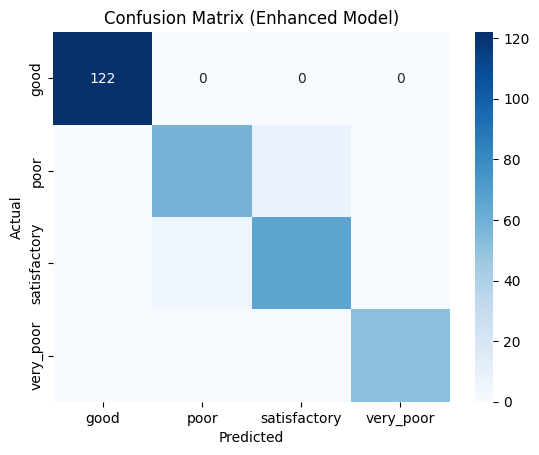

In [29]:
# Evaluate the Enhanced Model
test_preds, test_labels = evaluate_model(enhanced_model, test_loader)

# Classification Report
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Enhanced Model)")
plt.show()

In [30]:
torch.save(model.state_dict(), "road_damage_model2.pth")
print("Model saved as road_damage_model2.pth")


Model saved as road_damage_model2.pth
